In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss=1.0501, Val Loss=0.9559, Train Acc=54.86%, Val Acc=55.73%
Epoch 2: Train Loss=0.9148, Val Loss=0.8785, Train Acc=60.51%, Val Acc=58.27%
Epoch 3: Train Loss=0.8019, Val Loss=0.7371, Train Acc=67.05%, Val Acc=70.23%
Epoch 4: Train Loss=0.6964, Val Loss=0.6519, Train Acc=74.73%, Val Acc=79.13%
Epoch 5: Train Loss=0.6690, Val Loss=0.6070, Train Acc=77.27%, Val Acc=81.68%
Epoch 6: Train Loss=0.6178, Val Loss=0.5592, Train Acc=80.25%, Val Acc=85.24%
Epoch 7: Train Loss=0.5917, Val Loss=0.5978, Train Acc=83.56%, Val Acc=82.70%
Epoch 8: Train Loss=0.5702, Val Loss=0.5261, Train Acc=83.94%, Val Acc=87.02%
Epoch 9: Train Loss=0.5604, Val Loss=0.4804, Train Acc=85.33%, Val Acc=89.82%
Epoch 10: Train Loss=0.5198, Val Loss=0.4766, Train Acc=86.92%, Val Acc=90.33%
Epoch 11: Train Loss=0.4904, Val Loss=0.4657, Train Acc=89.21%, Val Acc=91.35%
Epoch 12: Train Loss=0.4730, Val Loss=0.4433, Train Acc=90.35%, Val Acc=91.60%
Epoch 13: Train Loss=0.4870, Val Loss=0.4256, Train Acc=89.02

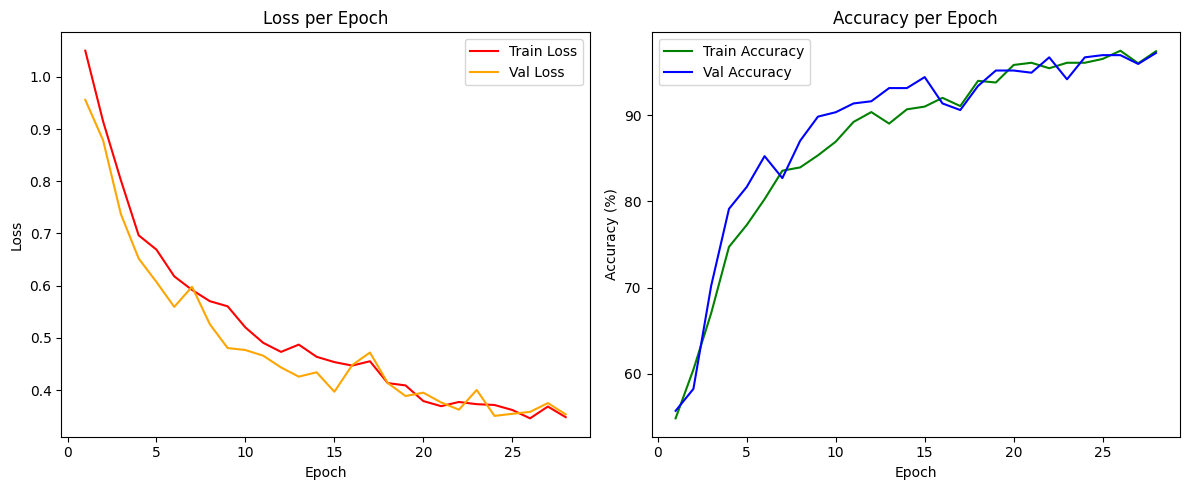


Test Accuracy: 81.78%


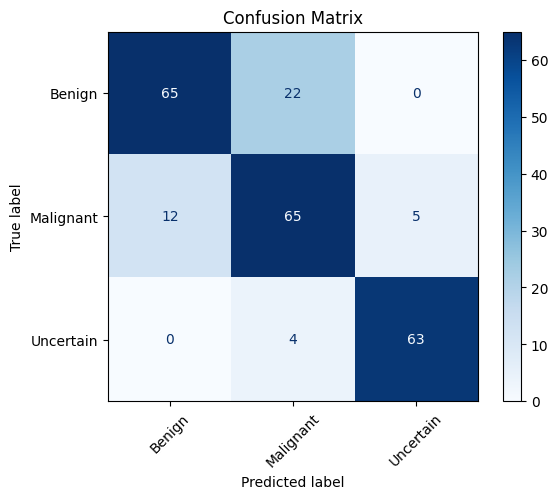


Classification Report:

              precision    recall  f1-score   support

      Benign       0.84      0.75      0.79        87
   Malignant       0.71      0.79      0.75        82
   Uncertain       0.93      0.94      0.93        67

    accuracy                           0.82       236
   macro avg       0.83      0.83      0.83       236
weighted avg       0.82      0.82      0.82       236



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms, datasets
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import os

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==================== Transforms ====================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ==================== Dataset Paths ====================
data_dir = "/content/drive/MyDrive/DL_dataset"
train_path = os.path.join(data_dir, "Train")
augmented_train_path = os.path.join(data_dir, "Augmented_Train")
test_path = os.path.join(data_dir, "Test")

sift_path = os.path.join(data_dir, "Processed/sift")
harris_path = os.path.join(data_dir, "Processed/harris")
bilateral_path = os.path.join(data_dir, "Processed/bilateral")

# ==================== Load Datasets ====================
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
augmented_train_dataset = datasets.ImageFolder(augmented_train_path, transform=train_transform)
sift_dataset = datasets.ImageFolder(sift_path, transform=train_transform)
harris_dataset = datasets.ImageFolder(harris_path, transform=train_transform)
bilateral_dataset = datasets.ImageFolder(bilateral_path, transform=train_transform)

# ==================== Combine Datasets ====================
combined_train_dataset = ConcatDataset([
    train_dataset,
    augmented_train_dataset,
    sift_dataset,
    harris_dataset,
    bilateral_dataset
])

# ==================== Split into Train and Val ====================
val_size = int(0.2 * len(combined_train_dataset))
train_size = len(combined_train_dataset) - val_size
train_dataset, val_dataset = random_split(combined_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform  # Use test_transform for validation

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# ==================== Model Setup ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=3, drop_rate=0.3, attn_drop_rate=0.1)
model.to(device)

# ==================== Loss, Optimizer, Scheduler ====================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stop_patience = 4

# ==================== Training Loop ====================
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_vit_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# ==================== Load Best Model ====================
model.load_state_dict(torch.load('best_vit_model.pt'))

# ==================== Plot Loss & Accuracy ====================
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, val_losses, 'orange', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# ==================== Final Test Evaluation ====================
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix and Classification Report
custom_class_names = ["Benign", "Malignant", "Uncertain"]
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=custom_class_names))
